In [55]:
import os

# Set the environment variable
os.environ['SCIPY_USE_PROPACK'] = '1'

import numpy as np
import pandas as pd

# make matplotlib plots appear inside the notebook
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10 ############################ <-Use this to change the plot
from IPython.core.display import HTML
HTML("<style>.container { width:100%; }</style>")
import scipy as sp
import pickle
import os
import time

import pulp
from pulp import *
from numba import njit
from qpsolvers import solve_qp

In [153]:
def optimize_over_convex_hull(V_matrix, z_star):
    if V_matrix.shape[1] == 1:
        return V_matrix[:, 0], np.array([1])
    
    Q_matrix = V_matrix.T @ V_matrix
    q_vector = -V_matrix.T @ z_star
    A = np.ones((1, V_matrix.shape[1]))
    b = np.ones(1)
    opt_lambda = solve_qp(P=Q_matrix, q=q_vector, A=A, b=b, lb=np.zeros(V_matrix.shape[1]), solver="proxqp", verbose=False)


    return V_matrix @ opt_lambda, opt_lambda


def fcfw(atoms, x_star, max_iter=100):
    active_set = []
    active_set_index = [0]
    s0 = atoms[:, 0]
    nb_atoms = atoms.shape[1]
    grad_list = []

    xk = s0
    for iter in range(max_iter):
        grad_k = xk - x_star
        grad_list.append(np.linalg.norm(grad_k))
        cand = np.inf
        best_atom = -1
        for i in range(nb_atoms):
            if grad_k.dot(atoms[:, i]) < cand:
                cand = grad_k.dot(atoms[:, i])
                best_atom = i

        sk = atoms[:, best_atom]
        active_set.append(sk)
        active_set_index.append(best_atom)

        xk, opt_lambda = optimize_over_convex_hull(np.array(active_set).T, x_star)

        print(iter, best_atom, np.linalg.norm(grad_k), coeffs[best_atom])

    return xk, active_set, grad_list, opt_lambda, active_set_index          

In [178]:
n = 40
nb_atoms = 1000
atoms = 0.01 * np.random.rand(n, nb_atoms)

coeffs = np.random.rand(nb_atoms)
#coeffs[0:800] = 1e-6
coeffs = coeffs / np.sum(coeffs)
x_star = np.zeros(n)
for i in range(nb_atoms):
    x_star += coeffs[i] * atoms[:, i]
#x_star = 0.5 * atoms[:, 3] + 0.5 * atoms[:, 1]
atoms

array([[0.00595515, 0.00934599, 0.0002309 , ..., 0.00762171, 0.0030883 ,
        0.00985042],
       [0.00174903, 0.00949485, 0.00433634, ..., 0.00695438, 0.00932721,
        0.00636305],
       [0.00010412, 0.00207751, 0.00087622, ..., 0.00033847, 0.00160164,
        0.00827606],
       ...,
       [0.0005459 , 0.0022303 , 0.0082511 , ..., 0.00531415, 0.00453024,
        0.00447622],
       [0.00979879, 0.0088852 , 0.00474836, ..., 0.00587673, 0.0065808 ,
        0.00902781],
       [0.00887133, 0.00306185, 0.00701554, ..., 0.00200346, 0.00240796,
        0.00396407]])

In [179]:
xk, active_set, grad_list, opt_lambda, active_set_index = fcfw(atoms, x_star, max_iter=n + 10)

0 756 0.01761786575313915 0.001637680979435562
1 145 0.01907838296912418 0.0008119702224987365
2 726 0.009896335041627572 0.0007352233807944471
3 988 0.007245373957724834 0.0009367400757201886
4 737 0.005033703487540969 0.0005238404592728368
5 179 0.003581777888677429 0.0013293401466851365
6 961 0.0027622584599419457 0.0018212801870967092
7 535 0.0020648809831354275 0.0011862480095149734
8 695 0.0017128524382367398 2.1011826236069684e-05
9 467 0.00156657873072724 0.0015094396998111526
10 789 0.0013767365894547996 0.0015857270968140848
11 151 0.0012010439068731538 0.0006654035120449369
12 61 0.0010245058038108605 0.0008600252503738555
13 933 0.0008155660635934613 0.0008049203368851257
14 537 0.0006597957952634971 5.4986149780868384e-05
15 593 0.00056370795421379 0.0018010942898754713
16 188 0.0004407380377829537 0.0005935156007436392
17 966 0.0003678440609580279 5.349359995194138e-06
18 997 0.00031721987158010874 0.002101834389596465
19 242 0.0002635034373426854 0.0014206326529851096
20

Text(0.5, 1.0, 'Convergence in gradient norm for n = 40 and number of atoms = 1000')

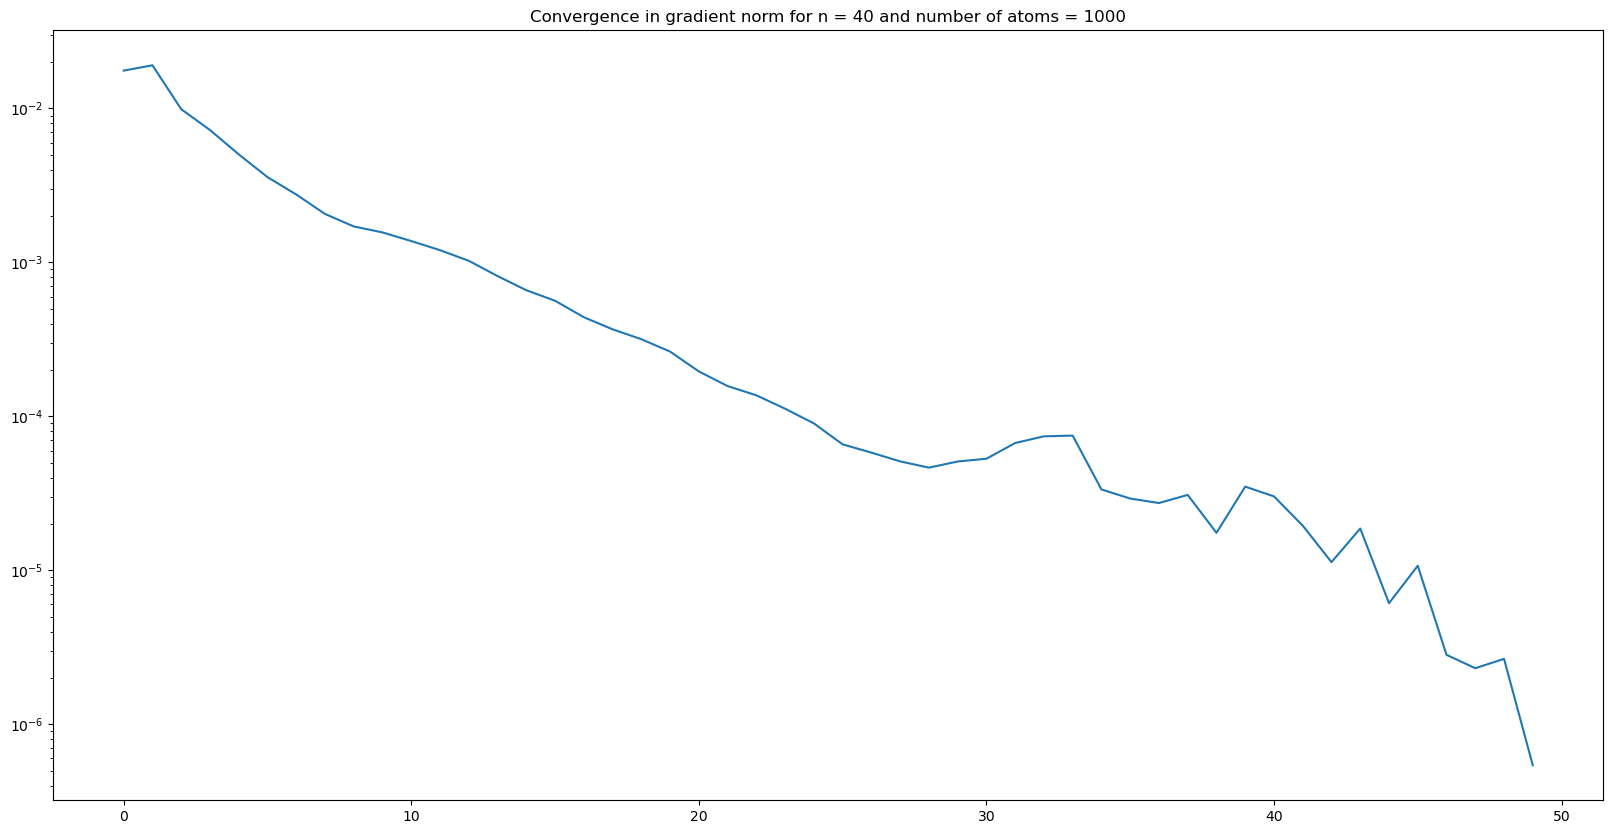

In [180]:
plt.plot(grad_list)
plt.yscale("log")
plt.title(f"Convergence in gradient norm for n = {n} and number of atoms = {nb_atoms}")

In [181]:
np.unique(active_set_index).shape

(51,)

In [246]:
for i in range(nb_atoms - 1):
    print(i, atoms[:, i].dot(atoms[:, i]), atoms[:, i].dot(atoms[:, i+1]))

0 600.862926258502 10026.125755927449
1 169710.89797138207 408481.41974461207
2 983216.0079984843 883188.9100208472
3 793340.6338163126 386880.2027220327
4 188671.02169073504 4183.78727190229
5 101.3178916156272 5024.7670144026115
6 272331.59986371076 394481.06037357147
7 571425.4317568525 648712.1115695944
8 736458.6127445371 596965.6012089589
9 483898.36886100256 370188.24349244824
10 283202.8740844069 194803.30818032208
11 133999.83159774306 186953.53000224847
12 260838.8778615091 221510.53349957766
13 188116.768709766 151043.86803248923
14 121280.48704753269 17971.975578511916
15 2671.2789115698906 12116.416785993983
16 55098.71188816638 51992.00914835852
17 49063.54691175195 48035.89770719114
18 47033.56459120908 158807.20553175118
19 536280.2720878446 670301.7900746611
20 837823.246178516 692372.4054543114
21 572176.3568605796 622130.6002588436
22 676452.0057389447 786752.2284672295
23 915045.1035626146 250861.05817665972
24 68780.3617317867 50384.41298419061
25 36911.14686983238

In [241]:
m = 30
n = 40
K = 100
nb_atoms = n * K
atoms = np.random.rand(n + m + 1, nb_atoms)
atoms[0, :] = 1000* np.random.rand(nb_atoms)
atoms[m+1:, :] = 0
for i in range(n):
    atoms[m+1+i, K*i:(i+1)*K] = np.ones(K) / n

coeffs = np.random.rand(nb_atoms)
#coeffs[0:800] = 1e-6
coeffs = coeffs / np.sum(coeffs)
coeffs = 1 / nb_atoms * np.ones(nb_atoms)
x_star = np.zeros(n+m+1)
for i in range(nb_atoms):
    x_star += coeffs[i] * atoms[:, i]
#x_star = 0.5 * atoms[:, 3] + 0.5 * atoms[:, 1]

In [242]:
xk, active_set, grad_list, opt_lambda, active_set_index = fcfw(atoms, x_star, max_iter=n + m + -3)

0 1162 485.70950473122105 0.00025
1 1341 489.8059744703644 0.00025
2 895 0.9402268010707819 0.00025
3 2296 0.5372436448414802 0.00025
4 1984 0.3759522307662665 0.00025
5 1978 0.29826833092904276 0.00025
6 3614 0.20920091044315098 0.00025
7 2073 0.15097983759752528 0.00025
8 3947 0.12433148197945658 0.00025
9 1098 0.10122035760828546 0.00025
10 3531 0.0754111030692474 0.00025
11 1340 0.05689087984427012 0.00025
12 814 0.03803123761459154 0.00025
13 627 0.025066955564529852 0.00025
14 1816 0.019459315744965497 0.00025
15 3278 0.01625644737452776 0.00025
16 83 0.013347166545702126 0.00025
17 1010 0.010881241281495068 0.00025
18 3726 0.00971984601989829 0.00025
19 654 0.009051581280861365 0.00025
20 191 0.008689935810185748 0.00025
21 3128 0.008590775758948484 0.00025
22 3469 0.008543188299383117 0.00025
23 964 0.008527334170245716 0.00025
24 1409 0.008499186820606684 0.00025
25 681 0.008459989738804644 0.00025
26 505 0.00840174251179664 0.00025
27 2720 0.008206970753287825 0.00025
28 674 

Text(0.5, 1.0, 'Convergence in gradient norm for n = 40 and number of atoms = 4000')

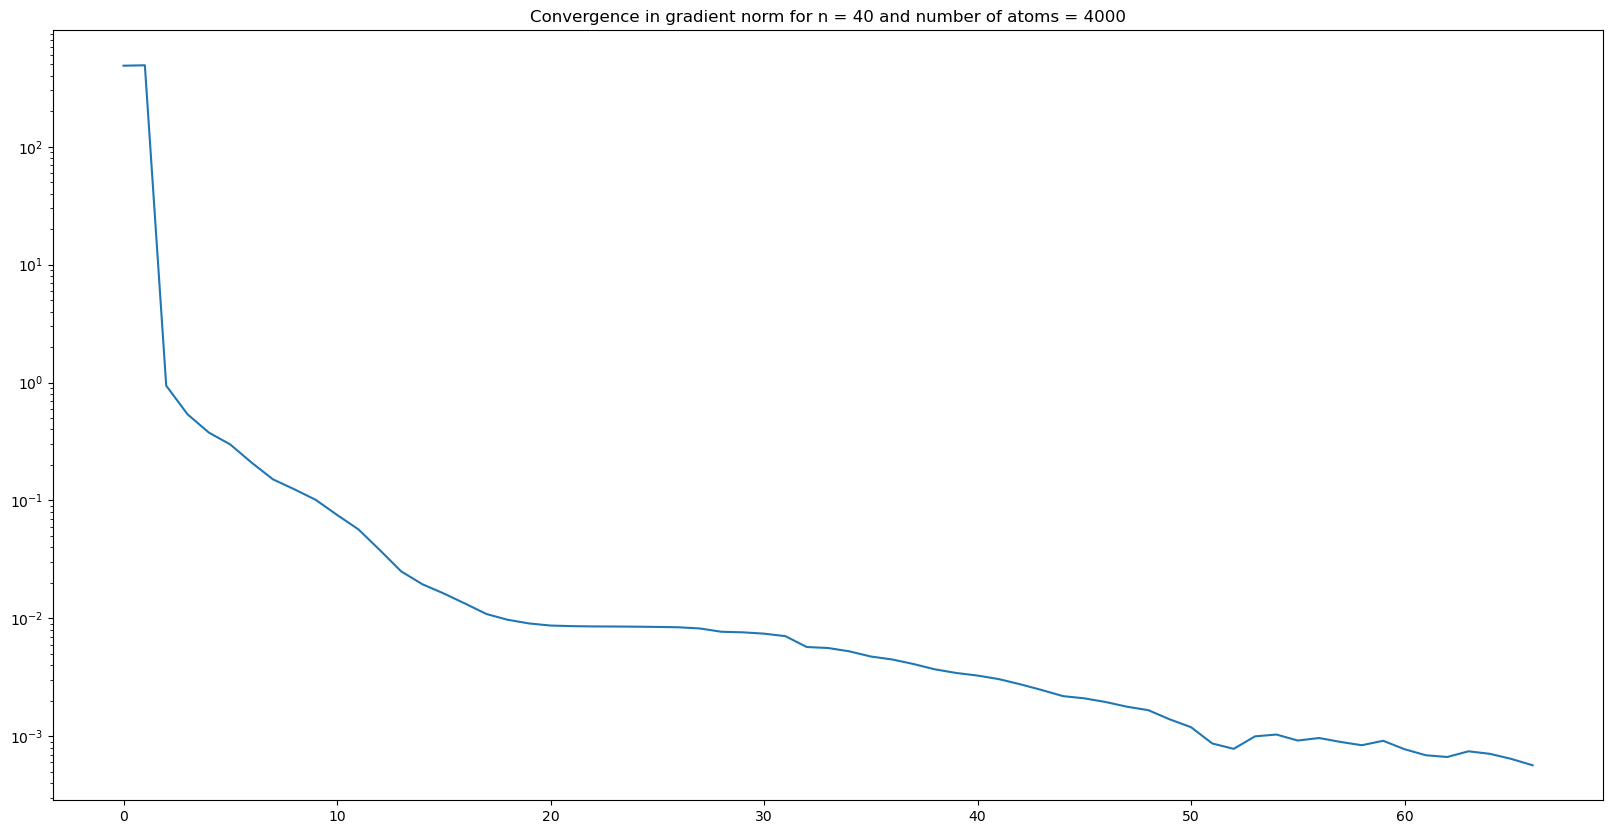

In [243]:
plt.plot(grad_list)
plt.yscale("log")
plt.title(f"Convergence in gradient norm for n = {n} and number of atoms = {nb_atoms}")

In [244]:
np.unique(np.floor(np.array(active_set_index )/K)).shape

(40,)

In [245]:
np.argsort(np.diag(atoms.T @ atoms))[::-1]

array([1162, 3740, 1095, ..., 2748, 1419, 1341])